In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import time 
import datetime
import statsmodels.api as sm
import pandas_datareader.data as web
import statsmodels.api as sm

In [2]:
def initDate(df):
    data=df
    data.set_index('Dates',drop=True,inplace=True)
    return data

In [3]:
def initTime(df):
    #Set the date index
    data=df
    data.set_index('Dates',drop=True,inplace=True)
    #Localize the HK time zone
    data.index=pd.to_datetime(data.index).tz_localize('Hongkong') #UTC-5
    #Convert the HK time zone to US to account for day light saving
    data.index=pd.to_datetime(data.index).tz_convert('US/Eastern') #UTC-5
    data['date']=data.index.date
    return data



In [4]:
def fm_summary(p):#Summary Statistics Function
    t=pd.Series((v for v in p ))
    s = t.describe().T
    s['Up Mean']=p[p>0].mean()
    s['Down Mean']=p[p<0].mean()
    s['Up Median']=p[p>0].median()
    s['Down Median']=p[p<0].median()
    s['std_error'] = s['std']/np.sqrt(s['count'])
    s['tstat'] = s['mean']/s['std_error']
    s['Up']=t[t>0].count()
    s['Down']=t[t<0].count()
    s['breakeven']=t[t==0].count()
    s['Up(%)']=t[t>0].count()/s['count']
    s['Down(%)']=t[t<0].count()/s['count']
    return s[['count','mean','Up','Down','breakeven','Up Mean','Down Mean','Up Median','Down Median','Up(%)','Down(%)']].T



In [5]:
dailyf=pd.read_excel("DAILYVIXDATA.xlsx","VVIXDAILY")
dailyf2=pd.read_excel("DAILYVIXDATA.xlsx","DAILYVIXETF")
dailyf3=pd.read_excel("DAILYVIXDATA.xlsx","UX1UX2DAILY")
df1=pd.read_excel("UXVIX.xlsx","UX1")
df2=pd.read_excel("UXVIX.xlsx","UX2")

In [692]:
VVIX=dailyf.copy()#copy aja
ETF=dailyf2.copy()
UX12daily=dailyf3.copy()
UX1=df1.copy()
UX2=df2.copy()

In [693]:
list2=[UX1,UX2]#update date
for itm in list2:
    itm=initTime(itm)
VVIX=initDate(VVIX)
VVIX.index=pd.to_datetime(VVIX.index).tz_localize('US/Eastern') 
ETF=initDate(ETF)
ETF.index=pd.to_datetime(ETF.index).tz_localize('US/Eastern') 
UX12daily=initDate(UX12daily)
UX12daily.index=pd.to_datetime(UX12daily.index).tz_localize('US/Eastern') 

In [694]:
UX1test=UX1.between_time('15:55','16:15')
UX2test=UX2.between_time('15:55','16:15')

In [695]:
VVIX1=VVIX[['VVIX OPEN','VVIX HIGH','VVIX LAST','VVIX LOW','VVIX MA100']]
VIX1=VVIX[['VIX OPEN','VIX HIGH','VIX LAST','VIX LOW','VIX MA101']]
#SPLIT VVIX AND VIX

In [696]:
UX12daily['SpreadDT']=UX12daily['PX_LAST2']-UX12daily['PX_LAST']


In [697]:
UX12daily['SpreadDT-1']=UX12daily['SpreadDT'].shift(1)

### ETF 

In [698]:
ETF['FLOW%']=(ETF['FLOWTOTAL']-ETF['FLOWTOTAL'].shift(1))/ETF['FLOWTOTAL'].shift(1).abs()
ETF['NAVTOTAL%']=(ETF['NAVTOTAL']-ETF['NAVTOTAL'].shift(1))/ETF['NAVTOTAL'].shift(1).abs()
ETF['FLOW%T-1']=ETF['FLOW%'].shift(1)
ETF['NAVTOTAL%T-1']=ETF['NAVTOTAL%'].shift(1)

### VVIX

In [699]:
VVIX1['extreme']=VVIX1['VVIX LAST'].rolling(21).quantile(.95).median()

## Contango

In [700]:
layer=pd.concat([UX1test['Close'],UX2test['Close']],axis=1,join='inner')
layer.columns=['Close1','Close2']
layer['Date']=layer.index.date
layer['Spread']=layer['Close2']-layer['Close1']
contango=layer.copy()#[spread['Spread']>0.15]


In [701]:
a=contango.at_time('15:55').set_index('Date')['Spread']
b=contango.at_time('16:00').set_index('Date')['Spread']
c=contango.at_time('16:05').set_index('Date')['Spread']
d=contango.at_time('16:14').set_index('Date')['Spread']
a.index=pd.to_datetime(a.index).tz_localize('US/Eastern')
b.index=pd.to_datetime(b.index).tz_localize('US/Eastern')
c.index=pd.to_datetime(c.index).tz_localize('US/Eastern')
d.index=pd.to_datetime(d.index).tz_localize('US/Eastern')
e=UX12daily['SpreadDT-1']
stat=pd.concat([a,d,e],axis=1,join='inner') #b,c
stat.columns=['15:55','16:14','SpreadDT-1'] #'16:00','16:05',
stat['Long1']=stat['16:14']-stat['15:55']
#stat['Long2']=stat['16:14']-stat['16:00']
#stat['Long3']=stat['16:14']-stat['16:05']
stat['Long1_ret']=(stat['16:14']-stat['15:55'])/stat['15:55'].abs()
stat['actual_signal']=np.where(stat['Long1_ret']>0,1,-1)

In [702]:
##VVIX and ETF combination
strategy=pd.concat([stat,ETF[['FLOW%','FLOW%T-1','NAVTOTAL%','NAVTOTAL%T-1']],],axis=1,join='inner')


In [703]:
strategy1=pd.concat([strategy,VVIX1[['VVIX HIGH','extreme']]],axis=1,join='inner')


In [704]:
strategy1['Benchmark']=strategy1['Long1_ret']

## Strategy Contango

In [705]:
conditions=[(strategy1['SpreadDT-1']>0.1),(strategy1['SpreadDT-1']<-0.1)]
values=[1,0]
strategy1['CBSignal']=np.select(conditions,values) #Contango Backwardation Signal
strategy1['CBReturn']=strategy1['CBSignal']*strategy1['Long1_ret']

## Strategy VVIX

In [558]:
#missing some 0 return for regression
#strategy1=strategy1.drop(strategy1.loc['2020-11-04':'2020-11-06'].index)

In [706]:
#VVIX
strategy1[(strategy1['VVIX HIGH']>strategy1['extreme'])&(strategy1['SpreadDT-1']<0)]['Long1_ret'].median()

-0.28730158730159183

In [707]:
conditions=[(strategy1['VVIX HIGH']>strategy1['extreme'])&(strategy1['SpreadDT-1']<0),(strategy1['VVIX HIGH']<strategy1['extreme'])&(strategy1['SpreadDT-1']<0),(strategy1['SpreadDT-1']>0)]
values=[-1,1,1]

In [708]:
strategy1['VVIXSIGNAL']=np.select(conditions,values)

In [709]:
strategy1['VVIX RETURN']=strategy1['VVIXSIGNAL']*strategy1['Long1_ret']

## Strategy ETF

In [710]:
ETFTEST=strategy1[['FLOW%T-1','NAVTOTAL%T-1','NAVTOTAL%','Long1_ret','Long1','SpreadDT-1']].copy()
ETFTEST.replace([np.inf,-np.inf],np.nan,inplace=True)

In [711]:
ETFTEST=ETFTEST.fillna(method='ffill')

In [712]:
model=sm.OLS(ETFTEST['Long1_ret'],sm.add_constant(ETFTEST[['NAVTOTAL%T-1','SpreadDT-1']]))
model.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Long1_ret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.1875
Date:                Tue, 01 Dec 2020   Prob (F-statistic):              0.829
Time:                        09:33:52   Log-Likelihood:                -76.470
No. Observations:                 129   AIC:                             158.9
Df Residuals:                     126   BIC:                             167.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0138      0.059      0.234      0.815      -0.103       0.131
NAVTOTAL%T-1     0.3515      0.819      0.429      0.668      -1.269       1.972
SpreadDT-1       0.0113      0.024      0.466      0.642      -0.037       0.059
==============================================================================
Omnibus:                       52.834   Durbin-Watson:                   2.707
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2947.342
Skew:                          -0.056   Prob(JB):                         0.00
Kurtosis:                      26.416   Cond. No.                         53.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [713]:
#implementation in strategy1 data frame
strategy1=strategy1.fillna(method='ffill')

In [714]:
conditions=[(strategy1['NAVTOTAL%T-1']>0)&(strategy1['SpreadDT-1']>0.1),(strategy1['NAVTOTAL%T-1']<0)&(strategy1['SpreadDT-1']<0.1),strategy1['SpreadDT-1']<0.1,strategy1['SpreadDT-1']>0.1]
values=[1,-1,0,0]
strategy1['ETFSIGNAL']=np.select(conditions,values)
strategy1['ETF RETURN']=strategy1['ETFSIGNAL']*strategy1['Long1_ret']

### Strategy Optimization

In [715]:
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# Cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# Pandas datareader to get the data

In [716]:
import shap
shap.initjs()

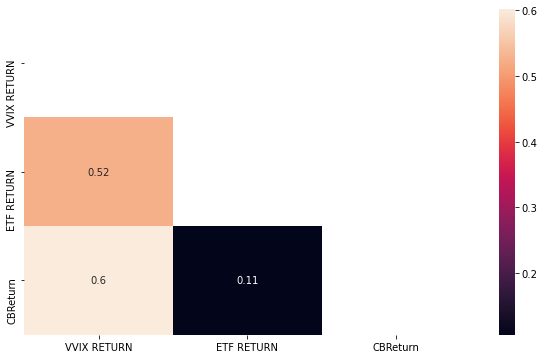

In [717]:
#Correlation Matrix
fig,ax=plt.subplots(figsize=(10,6))
mask = np.triu(np.ones_like(strategy1[['VVIX RETURN','ETF RETURN','CBReturn']].corr(), dtype=bool))
sns.heatmap(strategy1[['VVIX RETURN','ETF RETURN','CBReturn']].corr(),annot=True,mask=mask)

In [718]:
strategy1[['Long1_ret','SpreadDT-1','NAVTOTAL%T-1','VVIX HIGH','extreme','Benchmark','actual_signal']]

,Long1_ret,SpreadDT-1,NAVTOTAL%T-1,VVIX HIGH,extreme,Benchmark,actual_signal
2020-05-15 00:00:00-04:00,-0.153846,0.550,-0.065634,141.31,137.05,-0.153846,-1
2020-05-18 00:00:00-04:00,-0.076923,0.600,-0.005073,128.38,137.05,-0.076923,-1
2020-05-19 00:00:00-04:00,0.552941,1.175,-0.089057,126.26,137.05,0.552941,1
2020-05-21 00:00:00-04:00,-0.017857,1.665,-0.074028,123.63,137.05,-0.017857,-1
2020-05-22 00:00:00-04:00,0.296296,0.600,0.042098,121.67,137.05,0.296296,1
...,...,...,...,...,...,...,...
2020-11-19 00:00:00-05:00,0.100775,2.465,0.020993,117.46,137.05,0.100775,1
2020-11-20 00:00:00-05:00,-0.047619,1.450,-0.008515,113.99,137.05,-0.047619,-1
2020-11-23 00:00:00-05:00,-0.024845,1.450,-0.001335,114.09,137.05,-0.024845,-1
2020-11-24 00:00:00-05:00,-0.015873,1.625,-0.006095,109.30,137.05,-0.015873,-1


In [720]:
#Split data into training and testing set
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.Series()
y_test = pd.Series()
# Get predictor variables
X = strategy1[['SpreadDT-1','NAVTOTAL%T-1','VVIXSIGNAL']]
# Get the target variable
y = strategy1['actual_signal']
# Divide the dataset into train and test
train_length = int(len(X)*0.70)
X_train = X_train.append(X[:train_length])
X_test = X_test.append(X[train_length:])
y_train = y_train.append(y[:train_length])
y_test = y_test.append(y[train_length:])

In [721]:
#Initialize model set hyperparameter values
model=XGBClassifier(max_depth=2,n_estimators=30)

In [722]:
# Initialize the KFold parameters
kfold = KFold(n_splits=5, random_state=7)
# Perform K-Fold Cross Validation
results = cross_val_score(model, X_train, y_train, cv=kfold)
# Print the average results
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Accuracy: 67.78% (6.48%)


In [723]:
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=30, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

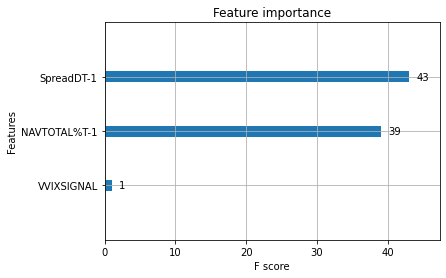

In [724]:
xgboost.plot_importance(model,max_num_features=7)
plt.show()

In [725]:
# Predict the trading signal on test dataset
y_pred = model.predict(X_test)
# Get the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.73      0.55      0.63        20
           1       0.62      0.79      0.70        19

    accuracy                           0.67        39
   macro avg       0.68      0.67      0.66        39
weighted avg       0.68      0.67      0.66        39



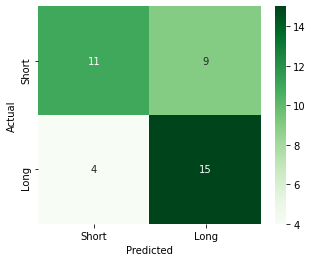

In [726]:
array = confusion_matrix(y_test, y_pred)
df = pd.DataFrame(array, index=['Short', 'Long'], columns=[
'Short', 'Long'])
plt.figure(figsize=(5, 4))
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

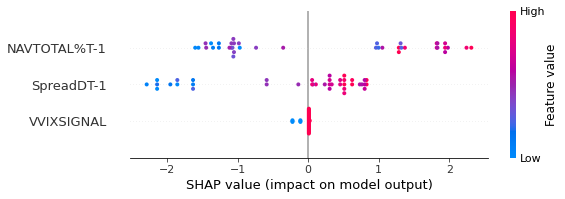

In [727]:
shap_values = shap.TreeExplainer(model).shap_values(X_test)
shap.summary_plot(shap_values, X_test)

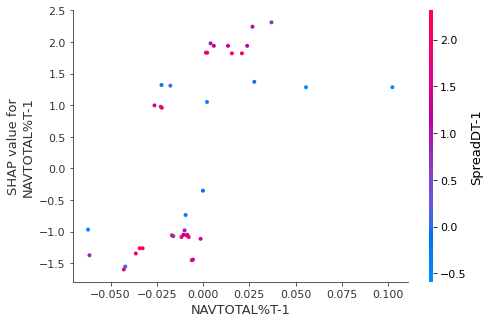

In [728]:
shap.dependence_plot("NAVTOTAL%T-1", shap_values, X_test, interaction_index="SpreadDT-1")

In [729]:
#predictor var
X
train_length=int(len(X)*0.7)
# Predict the signal and store in predicted signal column
strategy1['predicted_signal'] = model.predict(X)
# Calculate the strategy returns
strategy1['XGBOOST_returns'] = strategy1['Long1_ret']*strategy1['predicted_signal']
# Add the strategy returns to the portfolio dataframe
strategy1['XGBOOST_returns']


2020-05-15 00:00:00-04:00    0.153846
2020-05-18 00:00:00-04:00    0.076923
2020-05-19 00:00:00-04:00    0.552941
2020-05-21 00:00:00-04:00   -0.017857
2020-05-22 00:00:00-04:00    0.296296
                               ...   
2020-11-19 00:00:00-05:00    0.100775
2020-11-20 00:00:00-05:00   -0.047619
2020-11-23 00:00:00-05:00   -0.024845
2020-11-24 00:00:00-05:00    0.015873
2020-11-25 00:00:00-05:00   -0.036697
Name: XGBOOST_returns, Length: 129, dtype: float64

In [730]:
strategy1

,15:55,16:14,SpreadDT-1,Long1,Long1_ret,actual_signal,FLOW%,FLOW%T-1,NAVTOTAL%,NAVTOTAL%T-1,...,extreme,Benchmark,CBSignal,CBReturn,VVIXSIGNAL,VVIX RETURN,ETFSIGNAL,ETF RETURN,predicted_signal,XGBOOST_returns
2020-05-15 00:00:00-04:00,0.65,0.55,0.550,-0.10,-0.153846,-1,0.637975,-1.951717,-0.005073,-0.065634,...,137.05,-0.153846,1,-0.153846,1,-0.153846,0,-0.000000,-1,0.153846
2020-05-18 00:00:00-04:00,1.30,1.20,0.600,-0.10,-0.076923,-1,0.741861,0.637975,-0.089057,-0.005073,...,137.05,-0.076923,1,-0.076923,1,-0.076923,0,-0.000000,-1,0.076923
2020-05-19 00:00:00-04:00,0.85,1.32,1.175,0.47,0.552941,1,12.944243,0.741861,0.066086,-0.089057,...,137.05,0.552941,1,0.552941,1,0.552941,0,0.000000,1,0.552941
2020-05-21 00:00:00-04:00,0.56,0.55,1.665,-0.01,-0.017857,-1,7.310890,-0.867804,0.042098,-0.074028,...,137.05,-0.017857,1,-0.017857,1,-0.017857,0,-0.000000,1,-0.017857
2020-05-22 00:00:00-04:00,0.54,0.70,0.600,0.16,0.296296,1,-1.783796,7.310890,-0.020711,0.042098,...,137.05,0.296296,1,0.296296,1,0.296296,1,0.296296,1,0.296296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00-05:00,1.29,1.42,2.465,0.13,0.100775,1,8.561268,-1.320891,-0.008515,0.020993,...,137.05,0.100775,1,0.100775,1,0.100775,1,0.100775,1,0.100775
2020-11-20 00:00:00-05:00,1.47,1.40,1.450,-0.07,-0.047619,-1,-0.833452,8.561268,-0.001335,-0.008515,...,137.05,-0.047619,1,-0.047619,1,-0.047619,0,-0.000000,1,-0.047619
2020-11-23 00:00:00-05:00,1.61,1.57,1.450,-0.04,-0.024845,-1,-0.182345,-0.833452,-0.006095,-0.001335,...,137.05,-0.024845,1,-0.024845,1,-0.024845,0,-0.000000,1,-0.024845
2020-11-24 00:00:00-05:00,1.89,1.86,1.625,-0.03,-0.015873,-1,4.186265,-0.182345,-0.007769,-0.006095,...,137.05,-0.015873,1,-0.015873,1,-0.015873,0,-0.000000,-1,0.015873


,15:55,16:14,SpreadDT-1,Long1,Long1_ret,actual_signal,FLOW%,FLOW%T-1,NAVTOTAL%,NAVTOTAL%T-1,...,extreme,Benchmark,CBSignal,CBReturn,VVIXSIGNAL,VVIX RETURN,ETFSIGNAL,ETF RETURN,predicted_signal,XGBOOST_returns
2020-05-15 00:00:00-04:00,0.65,0.55,0.550,-0.10,-0.153846,-1,0.637975,-1.951717,-0.005073,-0.065634,...,137.05,-0.153846,1,-0.153846,1,-0.153846,0,-0.000000,-1,0.153846
2020-05-18 00:00:00-04:00,1.30,1.20,0.600,-0.10,-0.076923,-1,0.741861,0.637975,-0.089057,-0.005073,...,137.05,-0.076923,1,-0.076923,1,-0.076923,0,-0.000000,-1,0.076923
2020-05-19 00:00:00-04:00,0.85,1.32,1.175,0.47,0.552941,1,12.944243,0.741861,0.066086,-0.089057,...,137.05,0.552941,1,0.552941,1,0.552941,0,0.000000,1,0.552941
2020-05-21 00:00:00-04:00,0.56,0.55,1.665,-0.01,-0.017857,-1,7.310890,-0.867804,0.042098,-0.074028,...,137.05,-0.017857,1,-0.017857,1,-0.017857,0,-0.000000,1,-0.017857
2020-05-22 00:00:00-04:00,0.54,0.70,0.600,0.16,0.296296,1,-1.783796,7.310890,-0.020711,0.042098,...,137.05,0.296296,1,0.296296,1,0.296296,1,0.296296,1,0.296296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00-05:00,1.29,1.42,2.465,0.13,0.100775,1,8.561268,-1.320891,-0.008515,0.020993,...,137.05,0.100775,1,0.100775,1,0.100775,1,0.100775,1,0.100775
2020-11-20 00:00:00-05:00,1.47,1.40,1.450,-0.07,-0.047619,-1,-0.833452,8.561268,-0.001335,-0.008515,...,137.05,-0.047619,1,-0.047619,1,-0.047619,0,-0.000000,1,-0.047619
2020-11-23 00:00:00-05:00,1.61,1.57,1.450,-0.04,-0.024845,-1,-0.182345,-0.833452,-0.006095,-0.001335,...,137.05,-0.024845,1,-0.024845,1,-0.024845,0,-0.000000,1,-0.024845
2020-11-24 00:00:00-05:00,1.89,1.86,1.625,-0.03,-0.015873,-1,4.186265,-0.182345,-0.007769,-0.006095,...,137.05,-0.015873,1,-0.015873,1,-0.015873,0,-0.000000,-1,0.015873


## Backtesting

In [732]:
import pyfolio as pf
import empyrical as ep
import warnings
warnings.filterwarnings('ignore')

In [734]:
import pyfolio as pf

,15:55,16:14,SpreadDT-1,Long1,Long1_ret,actual_signal,FLOW%,FLOW%T-1,NAVTOTAL%,NAVTOTAL%T-1,...,extreme,Benchmark,CBSignal,CBReturn,VVIXSIGNAL,VVIX RETURN,ETFSIGNAL,ETF RETURN,predicted_signal,XGBOOST_returns
2020-05-15 00:00:00-04:00,0.65,0.55,0.550,-0.10,-0.153846,-1,0.637975,-1.951717,-0.005073,-0.065634,...,137.05,-0.153846,1,-0.153846,1,-0.153846,0,-0.000000,-1,0.153846
2020-05-18 00:00:00-04:00,1.30,1.20,0.600,-0.10,-0.076923,-1,0.741861,0.637975,-0.089057,-0.005073,...,137.05,-0.076923,1,-0.076923,1,-0.076923,0,-0.000000,-1,0.076923
2020-05-19 00:00:00-04:00,0.85,1.32,1.175,0.47,0.552941,1,12.944243,0.741861,0.066086,-0.089057,...,137.05,0.552941,1,0.552941,1,0.552941,0,0.000000,1,0.552941
2020-05-21 00:00:00-04:00,0.56,0.55,1.665,-0.01,-0.017857,-1,7.310890,-0.867804,0.042098,-0.074028,...,137.05,-0.017857,1,-0.017857,1,-0.017857,0,-0.000000,1,-0.017857
2020-05-22 00:00:00-04:00,0.54,0.70,0.600,0.16,0.296296,1,-1.783796,7.310890,-0.020711,0.042098,...,137.05,0.296296,1,0.296296,1,0.296296,1,0.296296,1,0.296296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00-05:00,1.29,1.42,2.465,0.13,0.100775,1,8.561268,-1.320891,-0.008515,0.020993,...,137.05,0.100775,1,0.100775,1,0.100775,1,0.100775,1,0.100775
2020-11-20 00:00:00-05:00,1.47,1.40,1.450,-0.07,-0.047619,-1,-0.833452,8.561268,-0.001335,-0.008515,...,137.05,-0.047619,1,-0.047619,1,-0.047619,0,-0.000000,1,-0.047619
2020-11-23 00:00:00-05:00,1.61,1.57,1.450,-0.04,-0.024845,-1,-0.182345,-0.833452,-0.006095,-0.001335,...,137.05,-0.024845,1,-0.024845,1,-0.024845,0,-0.000000,1,-0.024845
2020-11-24 00:00:00-05:00,1.89,1.86,1.625,-0.03,-0.015873,-1,4.186265,-0.182345,-0.007769,-0.006095,...,137.05,-0.015873,1,-0.015873,1,-0.015873,0,-0.000000,-1,0.015873


Start date,2020-05-15
End date,2020-11-25
Total months,6
,Backtest
Annual return,242.551%
Cumulative returns,87.814%
Annual volatility,422.69%
Sharpe ratio,1.54
Calmar ratio,3.01
Stability,0.34
Max drawdown,-80.505%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,78.70,2020-06-16,2020-06-30,NaT,NaN
1,19.70,2020-05-29,2020-06-05,2020-06-11,10
2,0.00,2020-05-15,2020-05-15,2020-05-15,1
3,0.00,2020-05-15,2020-05-15,2020-05-15,1
4,0.00,2020-05-15,2020-05-15,2020-05-15,1


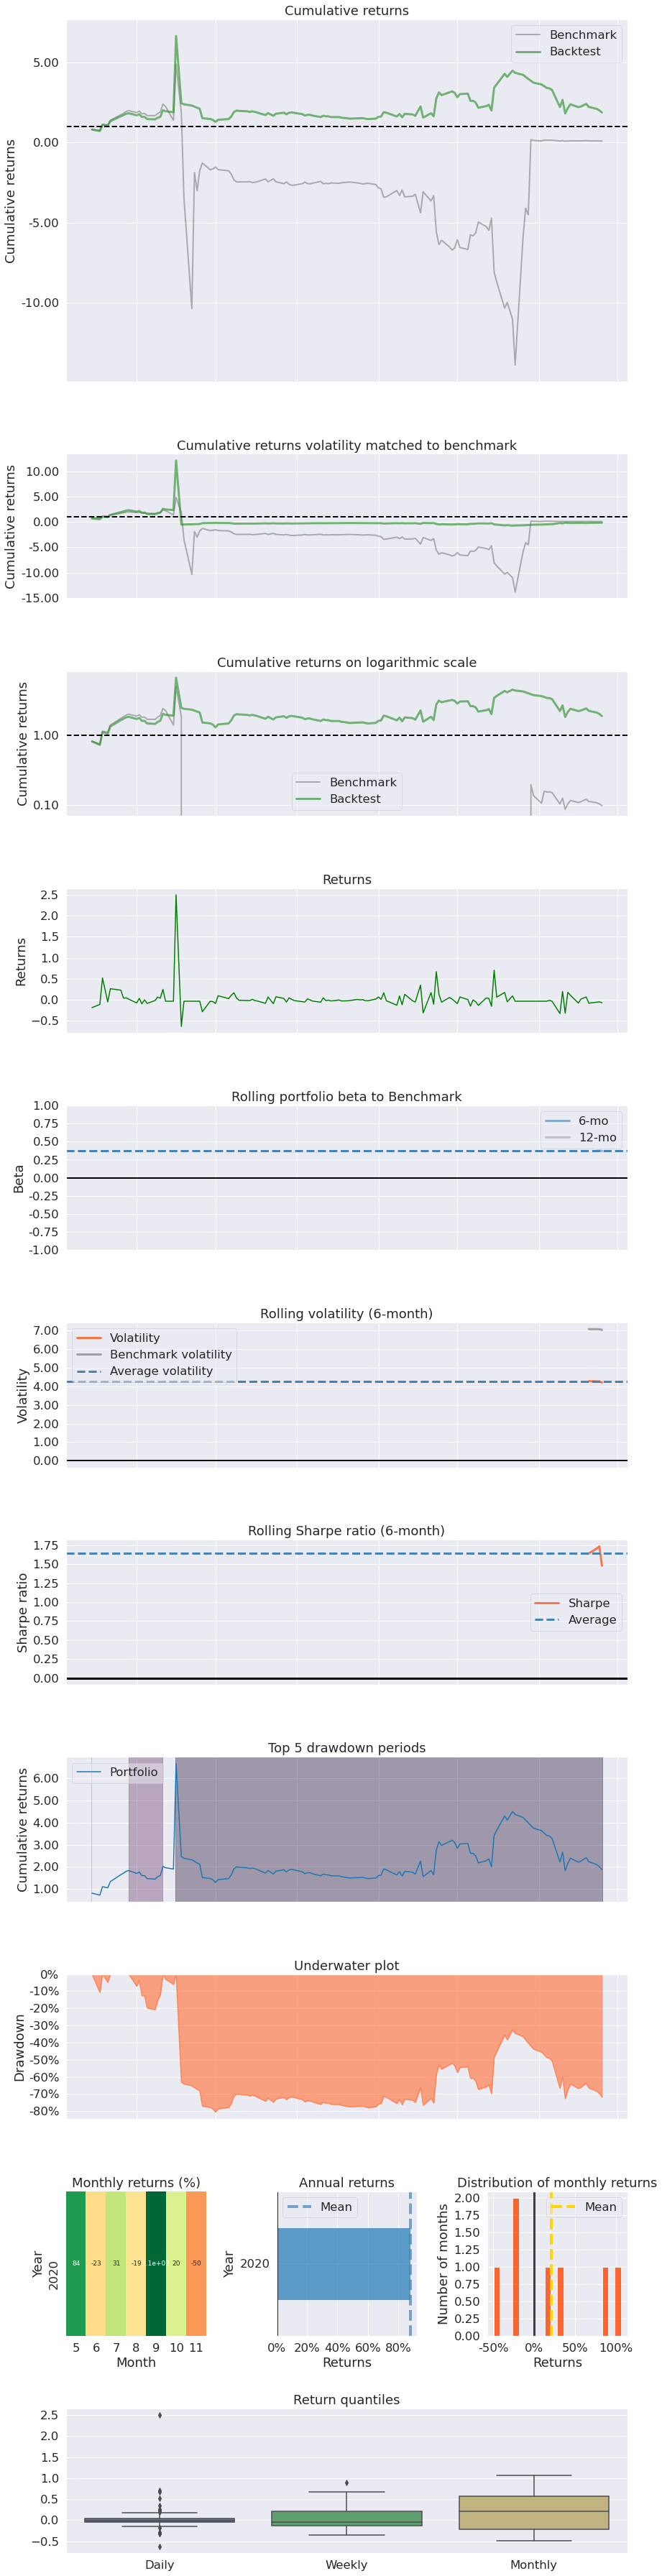

In [750]:
pf.create_full_tear_sheet((strategy1['CBReturn']-0.03),benchmark_rets=strategy1['Benchmark']-0.02)

In [741]:
strategy1

,15:55,16:14,SpreadDT-1,Long1,Long1_ret,actual_signal,FLOW%,FLOW%T-1,NAVTOTAL%,NAVTOTAL%T-1,...,extreme,Benchmark,CBSignal,CBReturn,VVIXSIGNAL,VVIX RETURN,ETFSIGNAL,ETF RETURN,predicted_signal,XGBOOST_returns
2020-05-15 00:00:00-04:00,0.65,0.55,0.550,-0.10,-0.153846,-1,0.637975,-1.951717,-0.005073,-0.065634,...,137.05,-0.153846,1,-0.153846,1,-0.153846,0,-0.000000,-1,0.153846
2020-05-18 00:00:00-04:00,1.30,1.20,0.600,-0.10,-0.076923,-1,0.741861,0.637975,-0.089057,-0.005073,...,137.05,-0.076923,1,-0.076923,1,-0.076923,0,-0.000000,-1,0.076923
2020-05-19 00:00:00-04:00,0.85,1.32,1.175,0.47,0.552941,1,12.944243,0.741861,0.066086,-0.089057,...,137.05,0.552941,1,0.552941,1,0.552941,0,0.000000,1,0.552941
2020-05-21 00:00:00-04:00,0.56,0.55,1.665,-0.01,-0.017857,-1,7.310890,-0.867804,0.042098,-0.074028,...,137.05,-0.017857,1,-0.017857,1,-0.017857,0,-0.000000,1,-0.017857
2020-05-22 00:00:00-04:00,0.54,0.70,0.600,0.16,0.296296,1,-1.783796,7.310890,-0.020711,0.042098,...,137.05,0.296296,1,0.296296,1,0.296296,1,0.296296,1,0.296296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19 00:00:00-05:00,1.29,1.42,2.465,0.13,0.100775,1,8.561268,-1.320891,-0.008515,0.020993,...,137.05,0.100775,1,0.100775,1,0.100775,1,0.100775,1,0.100775
2020-11-20 00:00:00-05:00,1.47,1.40,1.450,-0.07,-0.047619,-1,-0.833452,8.561268,-0.001335,-0.008515,...,137.05,-0.047619,1,-0.047619,1,-0.047619,0,-0.000000,1,-0.047619
2020-11-23 00:00:00-05:00,1.61,1.57,1.450,-0.04,-0.024845,-1,-0.182345,-0.833452,-0.006095,-0.001335,...,137.05,-0.024845,1,-0.024845,1,-0.024845,0,-0.000000,1,-0.024845
2020-11-24 00:00:00-05:00,1.89,1.86,1.625,-0.03,-0.015873,-1,4.186265,-0.182345,-0.007769,-0.006095,...,137.05,-0.015873,1,-0.015873,1,-0.015873,0,-0.000000,-1,0.015873


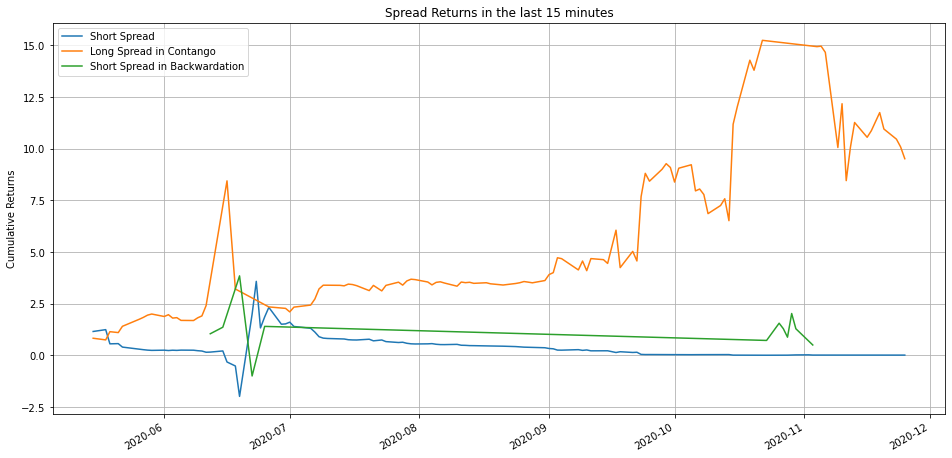

In [467]:
plt.figure(figsize=(16,8)) 
#(strategy1['Long1_ret']+1).cumprod().plot(label='Long Spread')
(-strategy1['Long1_ret']+1).cumprod().plot(label='Short Spread')
(strategy1[strategy1['SpreadDT-1']>0.1]['Long1_ret']+1-0.02).cumprod().plot(label='Long Spread in Contango')
(-(strategy1[strategy1['SpreadDT-1']<-0.1]['Long1_ret'])+1).plot(label='Short Spread in Backwardation')
plt.title('Spread Returns in the last 15 minutes')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.legend()
plt.show()

In [29]:
def initBacktest(data,name='Long1_ret'): #add 0 for no trading
    dummy=pd.DataFrame(0,index=pd.bdate_range('2020-05-15','2020-11-25').tz_localize('US/Eastern'),columns=['A'])
    tes2=pd.concat([dummy,data],axis=1)
    tes2=tes2.fillna(0)
    return tes2[name]

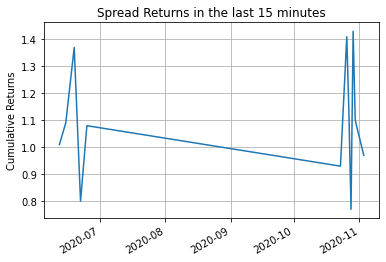

In [211]:
(-(strategy1[strategy1['SpreadDT-1']<-0.1]['Long1'])+1).plot(label='Short Spread in Backwardation')
plt.title('Spread Returns in the last 15 minutes')
plt.ylabel('Cumulative Returns')
plt.grid()
plt.show()


In [753]:
import pandas_datareader.data as web

In [940]:
NGETFLONG=web.DataReader('BOIL','yahoo')
NGETFSHORT=web.DataReader('KOLD','yahoo')
NGETFLONG['%LongBOIL']=NGETFLONG['Adj Close'].pct_change()
NGETFLONG=NGETFLONG.dropna()
NGETFLONG['%ShortBOIL']=NGETFLONG['%LongBOIL']*-1
NGETFSHORT['%LongKOLD']=NGETFSHORT['Adj Close'].pct_change()
NGETFSHORT=NGETFSHORT.dropna()
NGETFSHORT['%ShortKOLD']=NGETFSHORT['%LongKOLD']*-1


In [866]:
SPY=web.DataReader('SPY','yahoo')
SPY['change']=SPY['Adj Close'].pct_change()
SPY=SPY.dropna()

## Present a paper

In [878]:
strategy=pd.concat([NGETFLONG['%ShortBOIL'],NGETFSHORT['%ShortKOLD']],axis=1,join='inner')
strategy['ret']=strategy['%ShortBOIL']+strategy['%ShortKOLD']

In [879]:
strategy.index=pd.to_datetime(strategy.index).tz_localize('US/Eastern')

In [876]:
NGETFSHORT

,High,Low,Open,Close,Volume,Adj Close,%LongKOLD,%ShortKOLD
Date,,,,,,,,
2015-12-04,17.968000,17.952000,17.968,17.952000,2000.0,17.708071,0.100000,-0.100000
2015-12-07,23.926001,22.076000,22.076,23.804001,12000.0,23.480555,0.325980,-0.325980
2015-12-08,26.968000,22.704000,26.000,23.015200,30000.0,22.702473,-0.033137,0.033137
2015-12-09,23.667999,20.299999,21.888,22.695999,9000.0,22.387606,-0.013869,0.013869
2015-12-10,21.924000,21.528000,21.528,21.924000,11000.0,21.626099,-0.034015,0.034015
...,...,...,...,...,...,...,...,...
2020-04-27,16.000000,16.000000,16.000,16.000000,0.0,16.000000,0.000000,-0.000000
2020-04-28,16.000000,16.000000,16.000,16.000000,0.0,16.000000,0.000000,-0.000000
2020-04-29,16.000000,16.000000,16.000,16.000000,0.0,16.000000,0.000000,-0.000000


In [867]:
SPY.index=pd.to_datetime(SPY.index).tz_localize('US/Eastern')

Start date,2015-12-04
End date,2020-12-01
Total months,59
,Backtest
Annual return,7.053%
Cumulative returns,40.488%
Annual volatility,7.296%
Sharpe ratio,0.97
Calmar ratio,0.80
Stability,0.97
Max drawdown,-8.838%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,5.43,2018-11-13,2018-11-15,2019-01-18,49
1,1.66,2016-07-18,2016-07-20,2016-10-27,74
2,0.00,2016-06-24,2016-06-24,2016-06-24,1
3,0.00,2016-06-24,2016-06-24,2016-06-24,1
4,0.00,2016-06-24,2016-06-24,2016-06-24,1


Stress Events,mean,min,max
New Normal,0.03%,-4.05%,2.73%


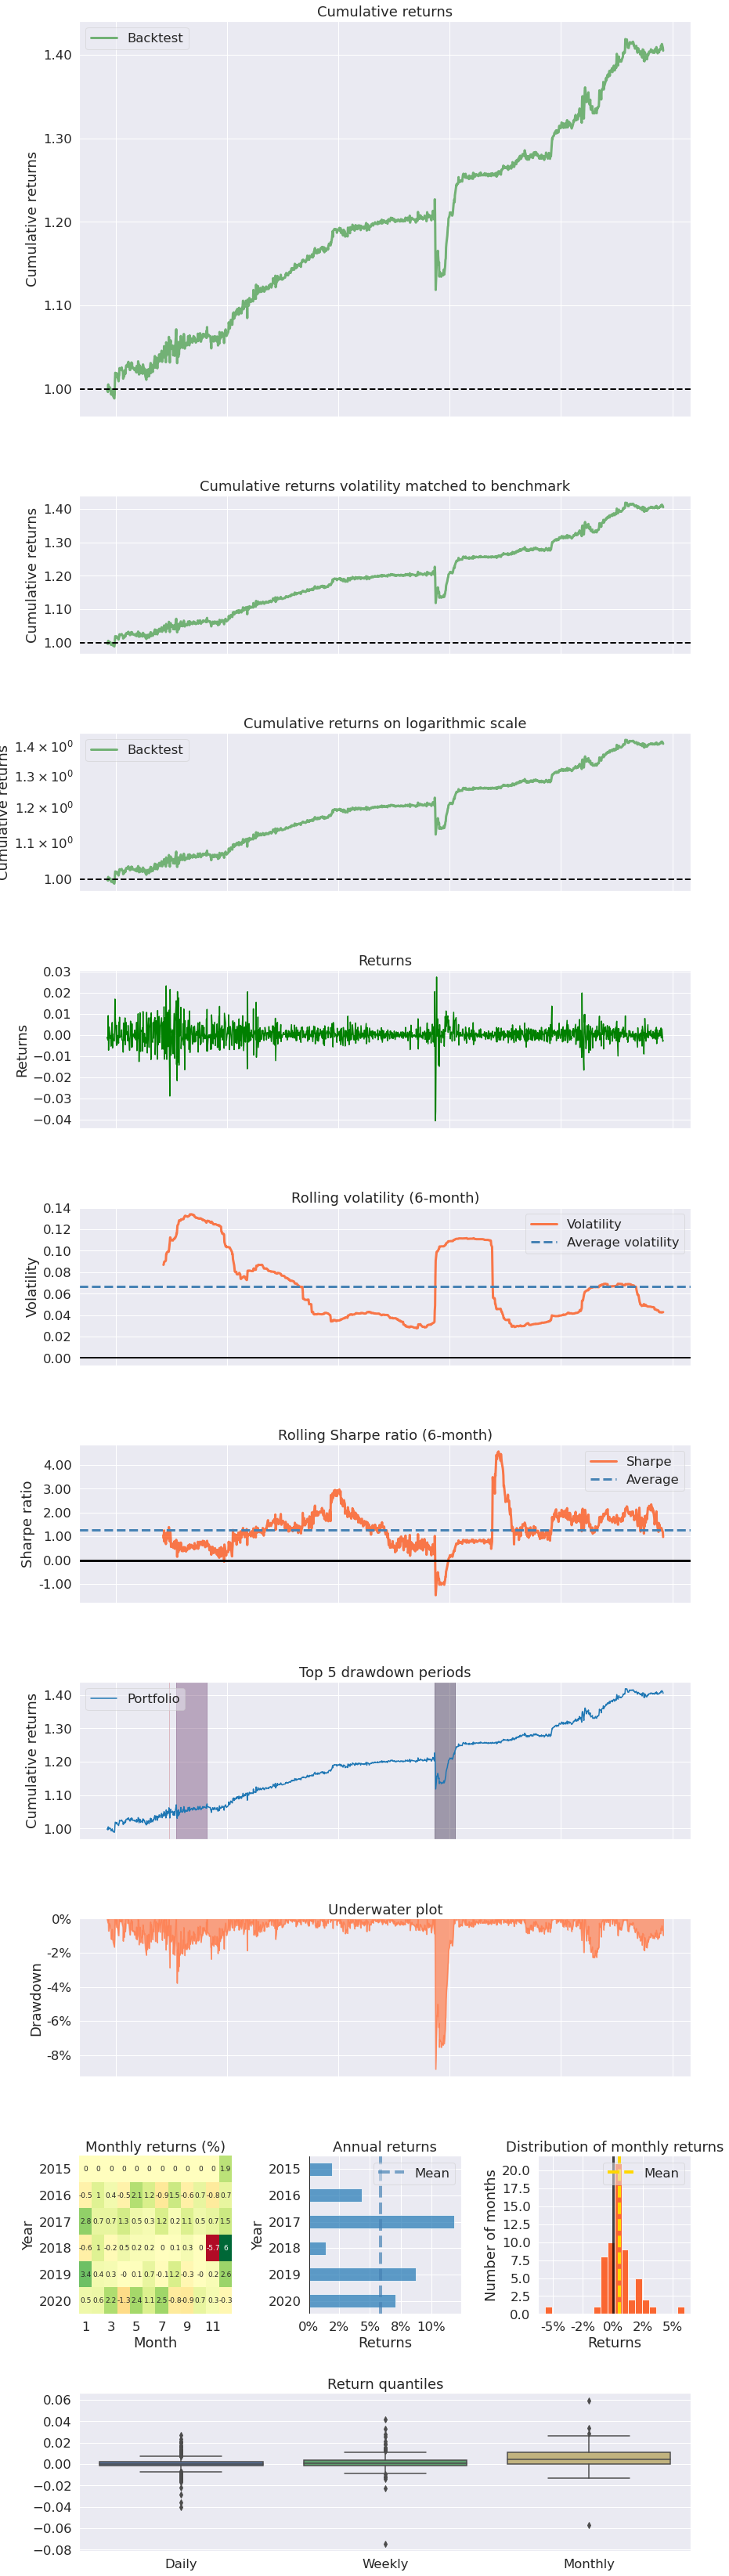

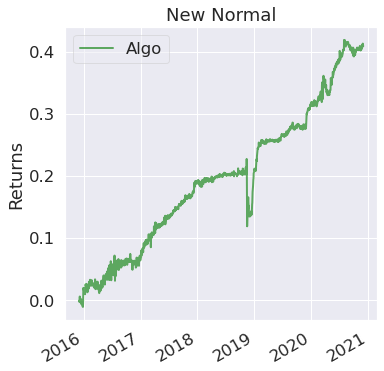

In [938]:
pf.create_full_tear_sheet(NGETFLONG['%ShortBOIL']+NGETFSHORT['%ShortKOLD'])

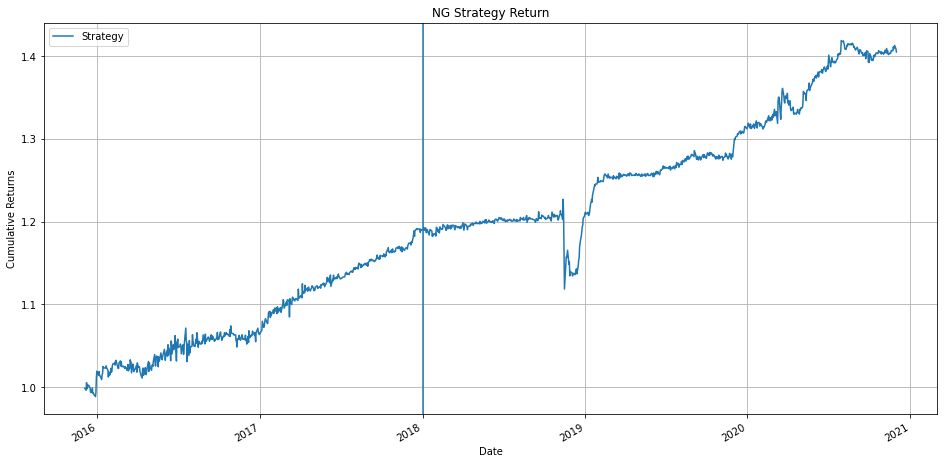

In [929]:
((NGETFSHORT['%ShortKOLD']+NGETFLONG['%ShortBOIL'])+1).cumprod().plot(figsize=(16,8),label='Strategy')
#(NGETFLONG['%LongBOIL']+1).cumprod().plot(figsize=(16,8),label='Long Boil')
#(NGETFSHORT['%LongKOLD']+1).cumprod().plot(figsize=(16,8),label='Long KOLD')
plt.title('NG Strategy Return')
plt.ylabel('Cumulative Returns')
plt.axvline('2018-01-01')
plt.legend()
plt.grid()
plt.show()


In [795]:
VIXS=web.DataReader('SVXY','yahoo')
VIXL=web.DataReader('UVXY','yahoo')
VIXS['%LongV']=VIXS['Adj Close'].pct_change()
VIXS=VIXS.dropna()
VIXS['%ShortV']=VIXS['%LongV']*-1
VIXL['%LongV']=VIXL['Adj Close'].pct_change()
VIXL=VIXL.dropna()
VIXL['%ShortV']=VIXL['%LongV']*-1

In [930]:
ACQ=VIXS=web.DataReader('AGQ','yahoo')
ZSL=VIXS=web.DataReader('ZSL','yahoo')


In [932]:
ACQ['Long']=ACQ['Adj Close'].pct_change()
ACQ=ACQ.dropna()
ACQ['Short']=ACQ['Long']*-1
ZSL['Long']=ZSL['Adj Close'].pct_change()
ZSL=ZSL.dropna()
ZSL['Short']=ZSL['Long']*-1

Start date,2015-12-04
End date,2020-12-01
Total months,59
,Backtest
Annual return,3.484%
Cumulative returns,18.629%
Annual volatility,4.502%
Sharpe ratio,0.78
Calmar ratio,0.74
Stability,0.50
Max drawdown,-4.692%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,4.56,2017-10-19,2019-09-26,2020-04-14,649
1,2.93,2020-05-26,2020-08-12,2020-11-11,122
2,1.57,2015-12-10,2016-01-15,2016-01-28,36
3,1.18,2016-04-15,2016-04-19,2016-05-06,16
4,0.08,2016-03-15,2016-03-16,2016-03-18,4


Stress Events,mean,min,max
New Normal,0.01%,-2.38%,1.91%


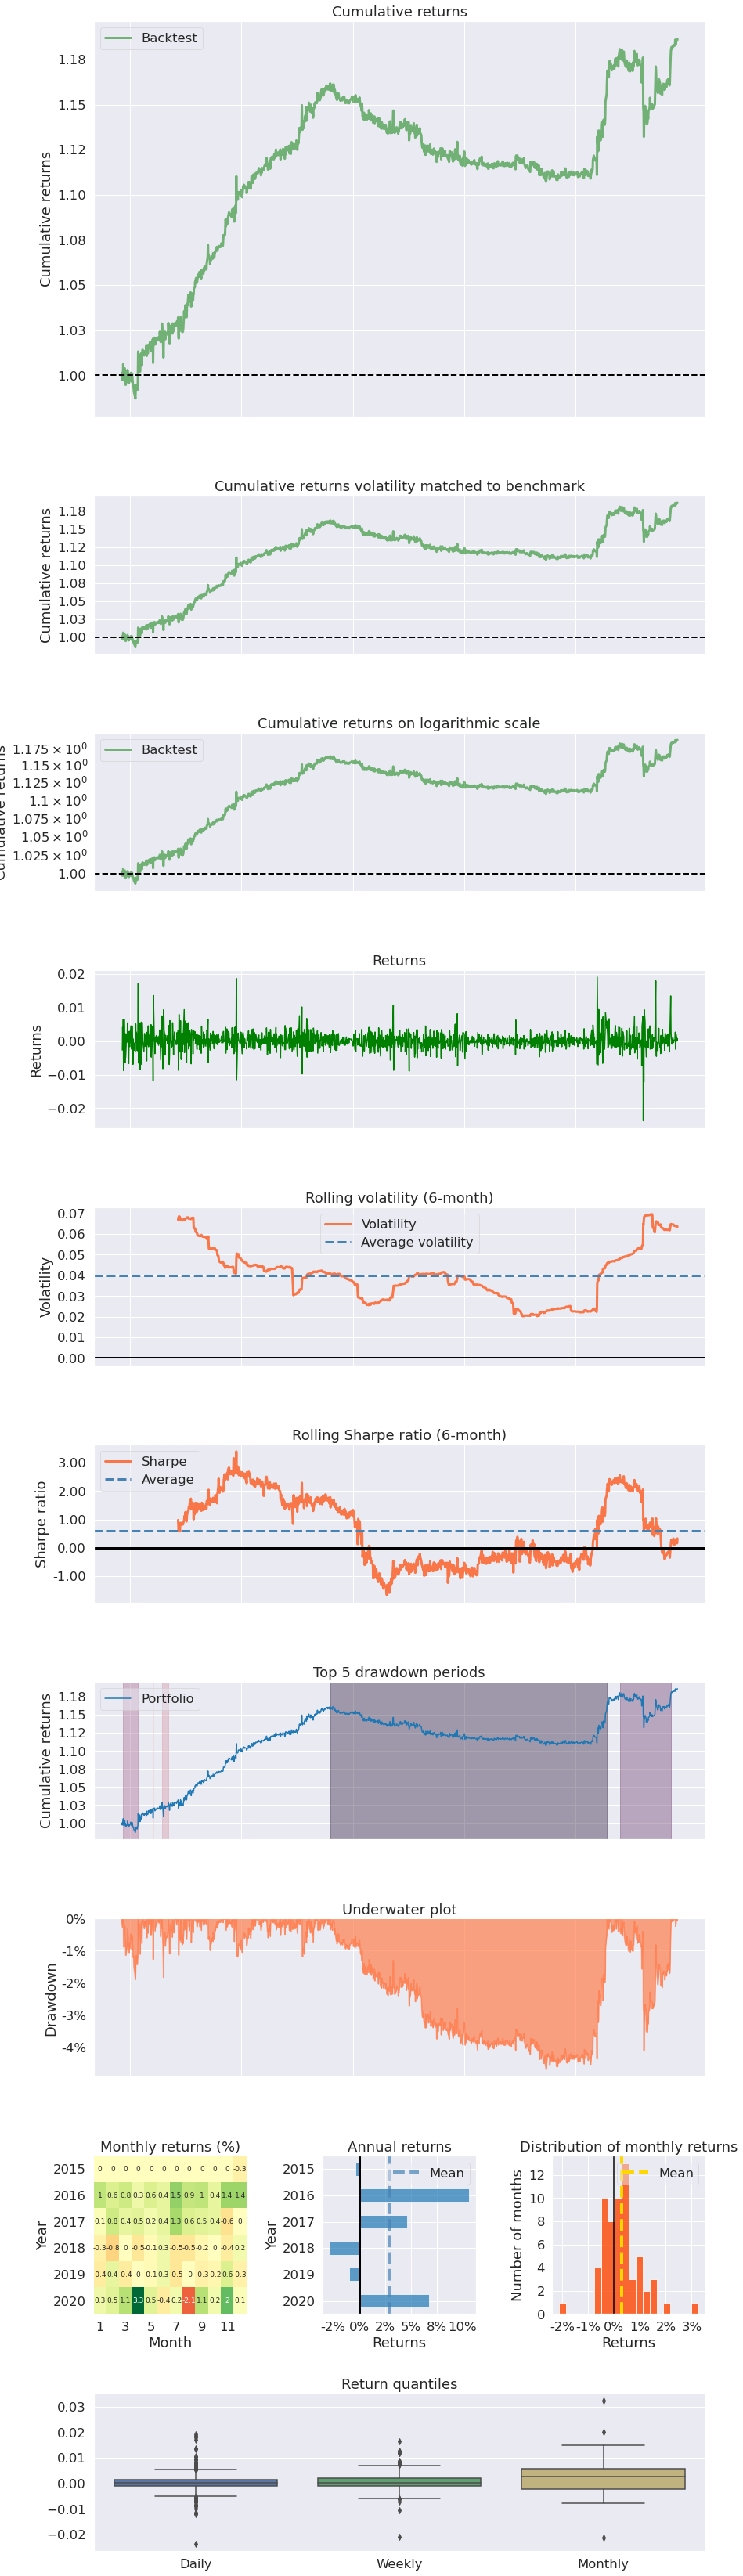

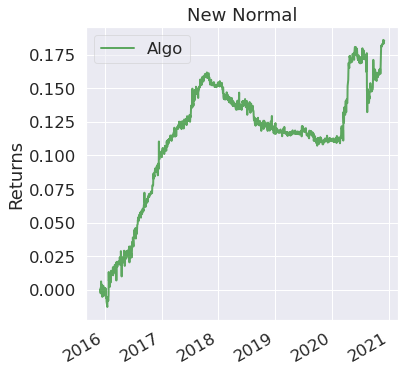

In [934]:
pf.create_full_tear_sheet(ACQ['Short']+ZSL['Short'])